### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])
#sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSBBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12930
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1368.2| 39.6372|-119.7094|       TMAX|USC00267691|     7|[80 4D 90 55 80 5...|2010.0|SSSBSBBB|
|   1368.2| 39.6372|-119.7094|       TMIN|USC00267691|    10|[A0 D3 80 D4 90 D...|2010.0|SSSBSBBB|
|   1369.5| 39.5333|-119.8167|       TMAX|USC00266782|    32|[80 54 30 55 90 5...|1893.0|SSSBSBBB|
|   1369.5| 39.5333|-119.8167|       TMAX|USC00266782|     0|[40 56 90 55 80 5...|1896.0|SSSBSBBB|
|   1369.5| 39.5333|-119.8167|       TMAX|USC00266782|     4|[30 55 90 55 30 5...|1897.0|SSSBSBBB|
+---------+--------+---------+-----------+-----------+------+-------------

In [2]:
df.show(15)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1368.2| 39.6372|-119.7094|       TMAX|USC00267691|     7|[80 4D 90 55 80 5...|2010.0|SSSBSBBB|
|   1368.2| 39.6372|-119.7094|       TMIN|USC00267691|    10|[A0 D3 80 D4 90 D...|2010.0|SSSBSBBB|
|   1369.5| 39.5333|-119.8167|       TMAX|USC00266782|    32|[80 54 30 55 90 5...|1893.0|SSSBSBBB|
|   1369.5| 39.5333|-119.8167|       TMAX|USC00266782|     0|[40 56 90 55 80 5...|1896.0|SSSBSBBB|
|   1369.5| 39.5333|-119.8167|       TMAX|USC00266782|     4|[30 55 90 55 30 5...|1897.0|SSSBSBBB|
|   1369.5| 39.5333|-119.8167|       TMAX|USC00266782|    12|[E0 54 30 55 E0 5...|1898.0|SSSBSBBB|
|   1369.5| 39.5333|-119.8167|       TMAX|USC00266782|     0|[80 54 80 49 00 0...|1899.0|SSSBSBBB|
|   1369.5

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USC00266782')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='TMAX' and station='USC00266782'
10 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1369.5| 39.5333|-119.8167|       TMAX|USC00266782|    32|[80 54 30 55 90 5...|1893.0|SSSBSBBB|
|   1369.5| 39.5333|-119.8167|       TMAX|USC00266782|     0|[40 56 90 55 80 5...|1896.0|SSSBSBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(10L, 365L)

In [3]:
query1 = "SELECT DISTINCT station FROM weather"
df2 = sqlContext.sql(query1)
print df2.count()

154


In [4]:
import sys
print(sys.version)

2.7.13 |Anaconda 4.3.1 (64-bit)| (default, Dec 19 2016, 13:29:36) [MSC v.1500 64 bit (AMD64)]


In [11]:
T

array([[  7.19921875,   8.296875  ,   8.8984375 , ...,   5.        ,
          5.        ,  11.1015625 ],
       [ 10.        ,   8.8984375 ,   4.3984375 , ...,   9.3984375 ,
         10.        ,  10.6015625 ],
       [  8.296875  ,   8.8984375 ,   8.296875  , ...,  10.        ,
         10.        ,   8.8984375 ],
       ..., 
       [ 11.703125  ,  10.        ,  11.703125  , ...,   3.30078125,
          4.3984375 ,   8.8984375 ],
       [  8.8984375 ,   9.3984375 ,  11.703125  , ...,   7.19921875,
          6.1015625 ,   7.19921875],
       [  3.90039062,   4.3984375 ,   5.        , ...,  14.3984375 ,
         12.203125  ,   3.30078125]], dtype=float16)

### Script for plotting yearly plots

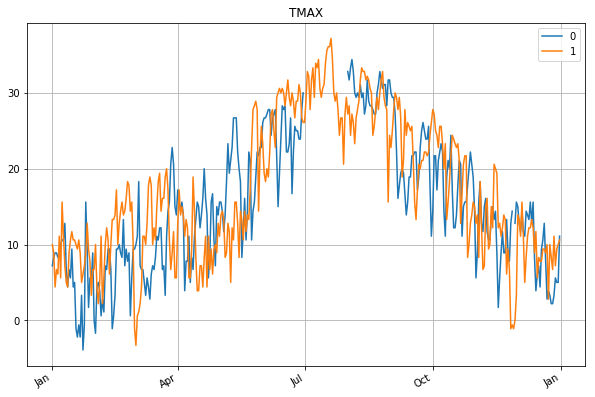

In [4]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='TMAX')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [6]:
numpy.version.version

'1.11.3'

In [5]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


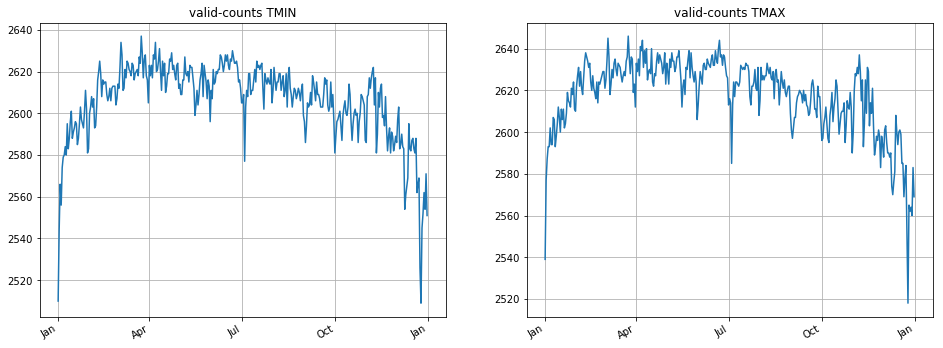

In [6]:
plot_pair(['TMIN','TMAX'],plot_valid)

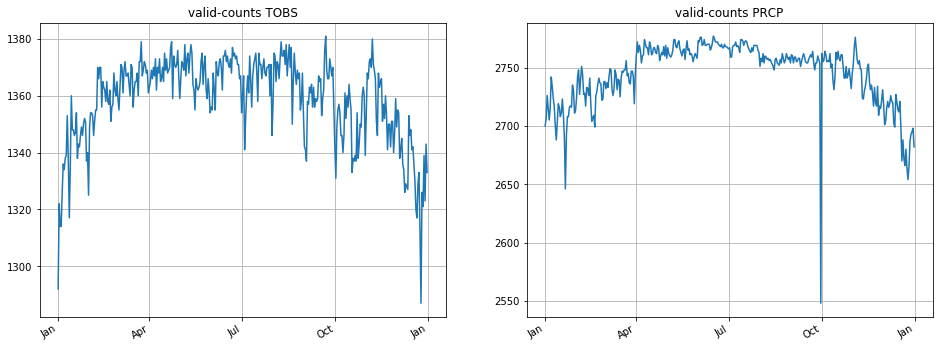

In [7]:
plot_pair(['TOBS','PRCP'],plot_valid)

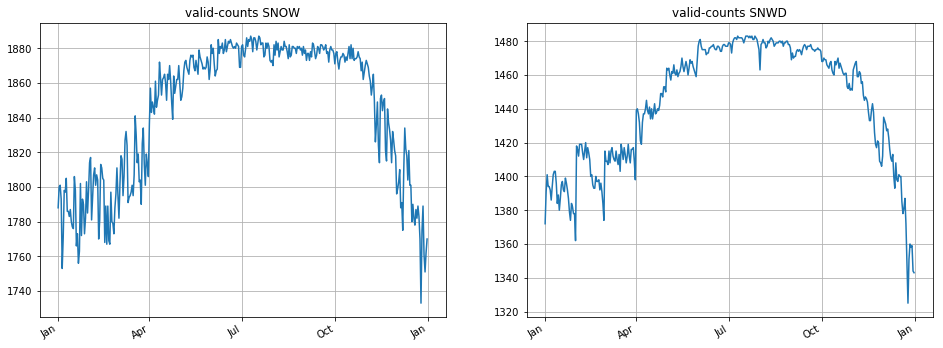

In [8]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [9]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    if m in ['TMIN','TMAX','TOBS'] :
        mean = mean/10.
        std = std/10.
        axis.set_xlabel('Month')
        axis.set_ylabel('Degrees Celsius')
    if m in ['PRCP'] :
        mean = mean/10.
        std = std/10.
        axis.set_xlabel('Month')
        axis.set_ylabel('Millimeters')        
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,labels=['mean - std','mean','mean+std'],title='Mean+-std   '+m)

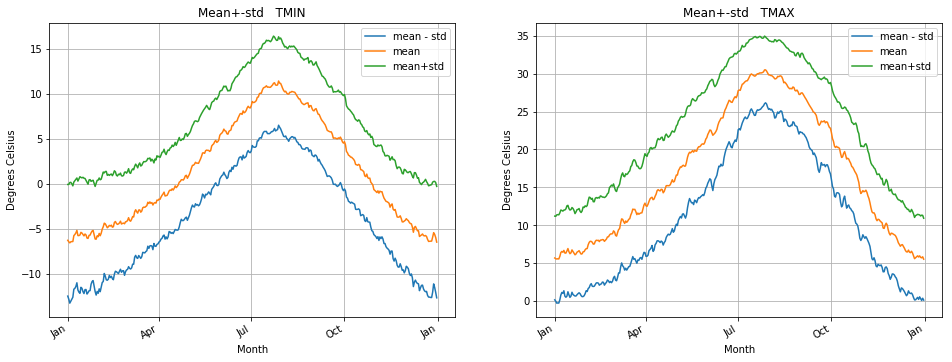

In [10]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

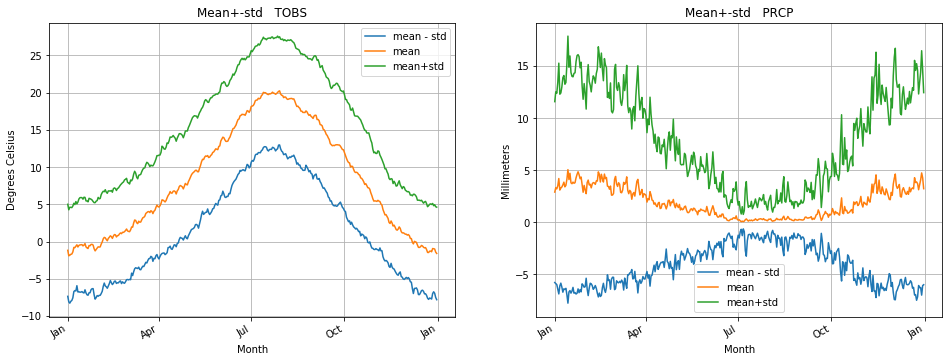

In [11]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

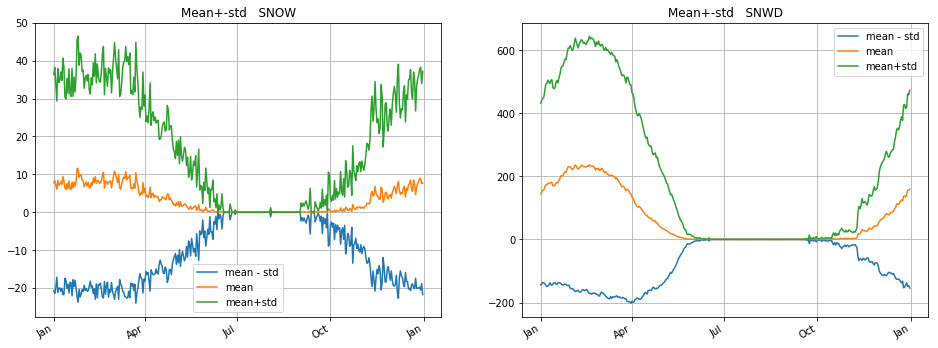

In [12]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [13]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

In [14]:
EV = STAT['SNWD']['eigvec']

In [15]:
shape(EV)

(365L, 365L)

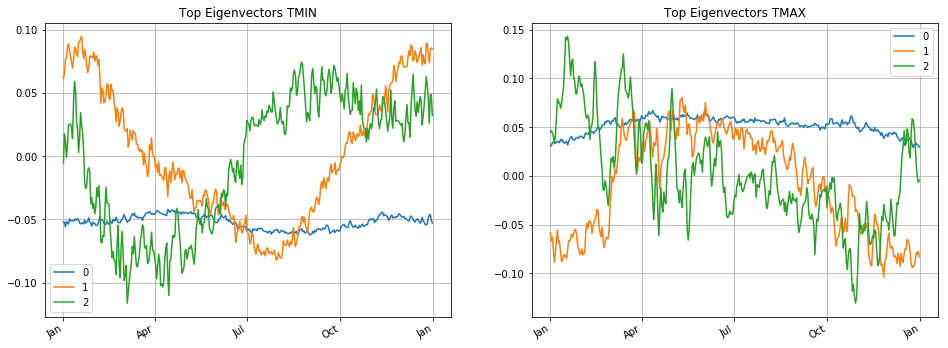

In [16]:
plot_pair(['TMIN','TMAX'],plot_eigen)

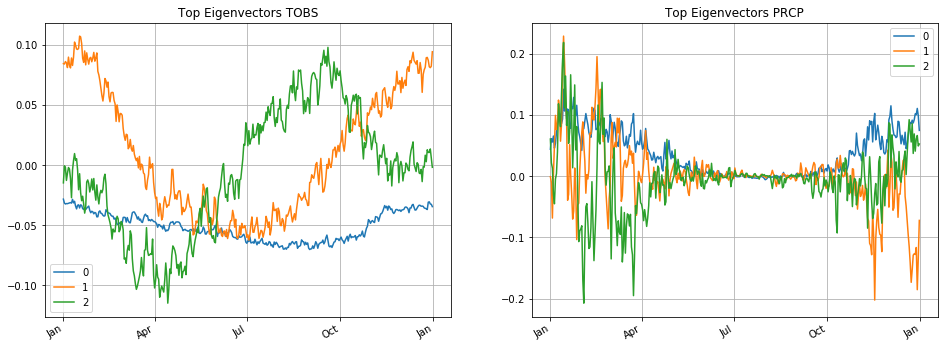

In [17]:
plot_pair(['TOBS','PRCP'],plot_eigen)

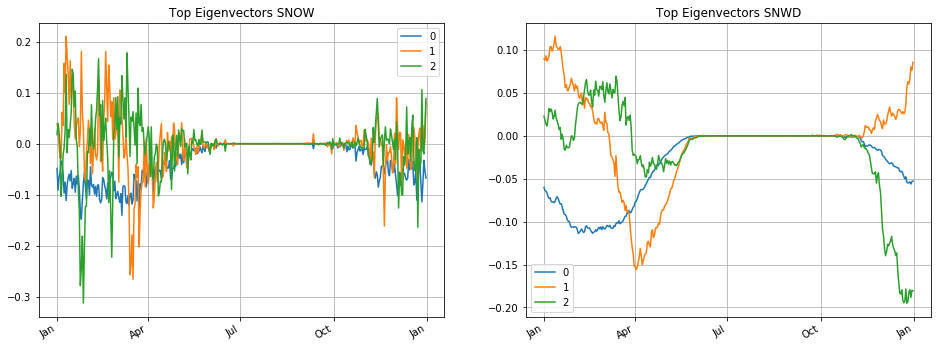

In [18]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [19]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

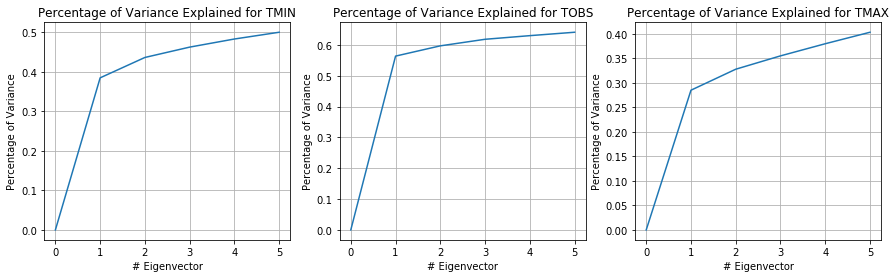

In [20]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

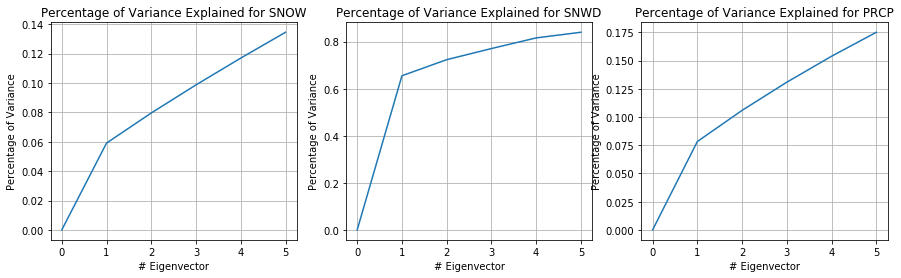

In [21]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()